In [3]:
import os
import torch
import numpy as np
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import random
import pandas as pd
from scipy import stats

device = torch.device("cuda")

# Function to calculate accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def compute_confidence_interval(data, confidence=0.68):
    mean = np.mean(data)
    sem = stats.sem(data)
    n = len(data)
    t_score = stats.t.ppf((1 + confidence) / 2., n-1)
    h = sem * t_score
    return mean, h

def best_cv_val(nested_list):
    array = np.array(nested_list)
    means = np.mean(array, axis=0)
    best_epoch = np.argmax(means)
    mean, ci = compute_confidence_interval(array[:, best_epoch])
    return best_epoch + 1, mean, ci

os.chdir('/home/kdoherty/spurge/data_release')
train_dir = './data/crop_39/train'

flat_stats = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
imagenet_stats = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

strategies = [flat_stats, imagenet_stats]
all_normalization_results = []

for strategy in strategies:
    batch_size = 32
    n_epochs = 50
    lr = 0.0005

    data_transforms = transforms.Compose([
        transforms.ToTensor(), 
       strategy
    ])

    full_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
    seeds = range(8)
    
    seed_epoch_accs = []

    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
    
        dataset_size = len(full_dataset)
        indices = list(range(dataset_size))
        random.shuffle(indices)
        train_indices = indices[:128]
        val_indices = indices[128:256]
    
        train_subset = Subset(full_dataset, train_indices)
        val_subset = Subset(full_dataset, val_indices)
    
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size)
    
        model = models.resnet50(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(nn.Linear(num_ftrs, 1))
    
        model = model.to(device)
        criterion = nn.BCEWithLogitsLoss().to(device)
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    
        epoch_accs = []

        with tqdm(total=n_epochs*len(train_loader), unit="batch", desc=f"LR: {lr} Seed: {seed}") as pbar:
            for epoch in range(n_epochs):
                model.train()
                running_loss = 0
    
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    output = model(images)
                    loss = criterion(output.squeeze(), labels.float())
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()
                    pbar.update(1)
    
                train_loss = running_loss/len(train_loader)
    
                # Validate the model
                model.eval()
                running_loss = 0
                running_acc = 0
    
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    acc = binary_accuracy(output.squeeze(), labels.float())
                    running_loss += loss.item()
                    running_acc += acc.item()
    
                val_loss = running_loss/len(val_loader)
                val_acc = running_acc/len(val_loader)
                epoch_accs.append(val_acc)
                
                pbar.set_postfix({'Learning rate': lr,
                                  'Seed':seed,
                                  'Epoch': epoch+1, 
                                  'Validation Loss': f'{val_loss:.3f}', 
                                  'Validation Accuracy': f'{val_acc:.3f}'})
                
        seed_epoch_accs.append(epoch_accs)
    
    best_epoch, best_accuracy, best_ci = best_cv_val(seed_epoch_accs)
    print(f'Strategy: {strategy}, Best epoch: {best_epoch}, Accuracy {best_accuracy}+/-[{best_ci}]')
    all_normalization_results.append({
        'strategy': strategy,
        'best_epoch': best_epoch,
        'accuracy': best_accuracy,
        'ci': best_ci
        
    })

LR: 0.0005 Seed: 7: 100%|████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.96batch/s, Learning rate=0.0005, Seed=7, Epoch=50, Validation Loss=0.000, Validation Accuracy=0.789]


Strategy: Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), Best epoch: 23, Accuracy 0.7451171875+/-[0.017377684943665102]


LR: 0.0005 Seed: 7: 100%|████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.80batch/s, Learning rate=0.0005, Seed=7, Epoch=50, Validation Loss=0.010, Validation Accuracy=0.711]

Strategy: Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), Best epoch: 31, Accuracy 0.7529296875+/-[0.013950335787306544]


In [4]:
df = pd.DataFrame(all_normalization_results)

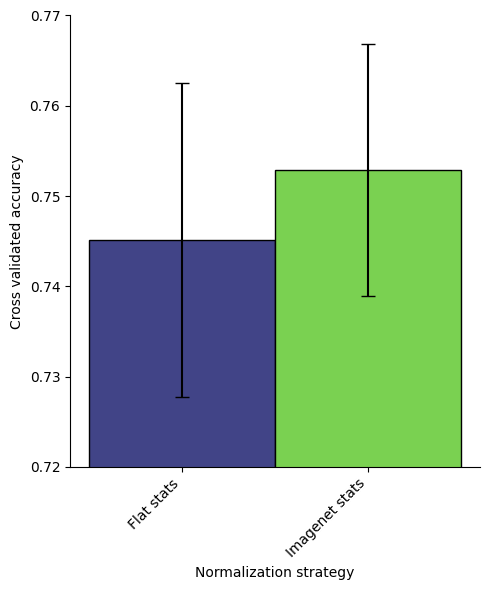

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(5, 6))

# Define bar width - a value less than 1.0 will make the bars narrower
bar_width = 1

# Use the viridis palette for the bars
cmap = plt.get_cmap('viridis')
colors = cmap([0.2, 0.8])  # Select two points in the colormap

# Create the barplot
bars = ax.bar(df.index * bar_width, df['accuracy'], color=colors, width=bar_width, align='center', yerr=df['ci'], capsize=5, edgecolor='black')

# Set the x-axis labels to the names provided in the strategy column
ax.set_xticks(df.index * bar_width)
ax.set_xticklabels(['Flat stats', 'Imagenet stats'], rotation=45, ha='right')

# Set the y-axis label
ax.set_ylabel('Cross validated accuracy')
ax.set_xlabel('Normalization strategy')

# Set the y-axis limits to better see the differences
ax.set_ylim(0.72, 0.77)

# Set the title of the plot
#ax.set_title('Model Accuracy with Confidence Intervals')

# Remove the top and right spines for a cleaner look
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Adjust the layout to ensure everything fits well
fig.tight_layout()

# Show the plot
plt.show()